In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from cli.cmonitor import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
toload = [ 
    # dict(name="base", id="faf6d-newbase_faf5y1_tightrtol_pvodefail_tuneres", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="test", id="faf7dd-legcond_asymp2_long_pvodefail_tuneres", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
    dict(name="base_tol", id="faf6e-newbase_faf5y1_tightrtol_pvodefail_tunerestol", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="test_tol", id="faf7de-legcond_asymp2_long_pvodefail_tunerestol", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
         
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

# Load both the data and debug files
cs = {}
debug = {}
for case in toload:
    name = case["name"]
    id = case["id"]
    cs[name] = db.load_case_2D(id, use_squash = case["squash"], verbose = True, keep_xboundaries = False, keep_yboundaries = False)


    path = str(db.casepaths[id])
    debug[name] = xbout.open_boutdataset(datapath=f"{path}/BOUT.debug.*.nc", geometry='toroidal',
                                gridfilepath=db.get_grid_path(id),
                                inputfilepath=os.path.join(path, "BOUT.inp"),
                                info=False, 
                                keep_xboundaries = False, keep_yboundaries = False
                                # grid_kw=dict(drop_variables=["offset_3x3"]), 
                                #use_modules=False
                            )

    debug[name] = debug[name].squeeze()

- Reading case faf6e-newbase_faf5y1_tightrtol_pvodefail_tunerestol
-----------------------


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(


- Reading case faf7de-legcond_asymp2_long_pvodefail_tunerestol
-----------------------


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(


# Load debug variables into xHermes dataset with metadata

In [11]:
dsd.dims

Frozen({'x': 20, 'theta': 50})

In [10]:
ds.dims

Frozen({'x': 20, 'theta': 58})

In [37]:
for case in cs:

    ds = cs[case].ds
    dsd = debug[case]
    eqns = []
    for var in dsd.data_vars:
        if "pre_" in var:
            eqns.append(var.split("_")[1])
            
    # eqns
    for var in dsd.data_vars:
        if any([x in var for x in ["pre_", "residuum", "track_ddt"]]):
            
            for eqn_name in eqns:
                if eqn_name in var:
                    eqn = eqn_name
                    break
            
            dsd[var].load()
            ds[var] = dsd[var].copy()
            ds[var].data = dsd[var].data
            ds[var].attrs = ds[eqn].attrs
            
            if "residuum" in var:
                ds[var].attrs.update(dict(short_name = "Residual", long_name = f"Residual of {eqn}", source = "sdtools", units = "-"))
            if "track_ddt" in var:
                id = var.split("_")[-1]
                ds[var].attrs.update(dict(short_name = "Term residual", long_name = f"Residual of {eqn}, term {id}", source = "sdtools", units = "-"))
            if "pre_" in var:
                ds[var].attrs.update(dict(short_name = f"{var} pre BC", long_name = f"{var} before BC applied", source = "sdtools", units = "-"))
            
            cs[case].ds = ds

# David's code to find most offending equation

In [5]:
if "Ne" in ds and "normalised_by" in ds.Ne.attrs:
    ds["Ne"] /= ds.Ne.attrs["normalised_by"]
    ds.Ne.attrs["normalised_by"]=1

def gettol(ds):
    try:
        atol = float(ds.options["solver:atol"])
    except KeyError:
        atol = 1e-12
    try:
        rtol = float(ds.options["solver:rtol"])
    except KeyError:
        rtol = 1e-5
    return atol, rtol


pre = "residuum_"
worst = {}
def get_res(ds, k):
        var = ds[k]
        res = ds[pre + k]
        atol, rtol = gettol(ds)
        err = abs(var) * rtol + atol
        where = abs(res) > err
        return res, err, where


def check_res(ds):
    keys = [k.split("_", 1)[1] for k in ds if k.startswith(pre)]
    for k in keys:
        print(f"Residuum for {k}:")
        res, err, where = get_res(ds, k)
        sumwhere = np.sum(where.compute())
        if not np.all(np.isfinite(err)):
            print(f"Not finite at {err.size - np.sum(np.isfinite(err))} of {err.size} points")
        if sumwhere:
            print(f"Above limit at {sumwhere} not fullfilled")
        else:
            print(f"Limit fullfilled everywhere")
        w = np.unravel_index(np.argmax(np.abs(res.values)), res.shape)
        print(f"Maximum residuum at {w}")
        worst[k] = w
        print("Maximum value is", np.max(err).values)
        
        
check_res(ds)

Residuum for NVd:
Limit fullfilled everywhere
Maximum residuum at (4, 21)
Maximum value is 8.988000758126807e-08
Residuum for NVd+:
Above limit at 19 not fullfilled
Maximum residuum at (2, 38)
Maximum value is 4.738276814349645e-06
Residuum for Nd:
Limit fullfilled everywhere
Maximum residuum at (3, 29)
Maximum value is 5.085327496597675e-06
Residuum for Nd+:
Limit fullfilled everywhere
Maximum residuum at (2, 5)
Maximum value is 7.084433565650967e-05
Residuum for Pd:
Limit fullfilled everywhere
Maximum residuum at (4, 20)
Maximum value is 1.267336083874954e-07
Residuum for Pd+:
Limit fullfilled everywhere
Maximum residuum at (2, 5)
Maximum value is 7.812164024671688e-05
Residuum for Pe:
Limit fullfilled everywhere
Maximum residuum at (2, 37)
Maximum value is 3.9457248362355454e-05


In [15]:
worst.keys()

dict_keys(['NVd', 'NVd+', 'Nd', 'Nd+', 'Pd', 'Pd+', 'Pe'])

# 2D plots of residuals

In [49]:
%matplotlib inline

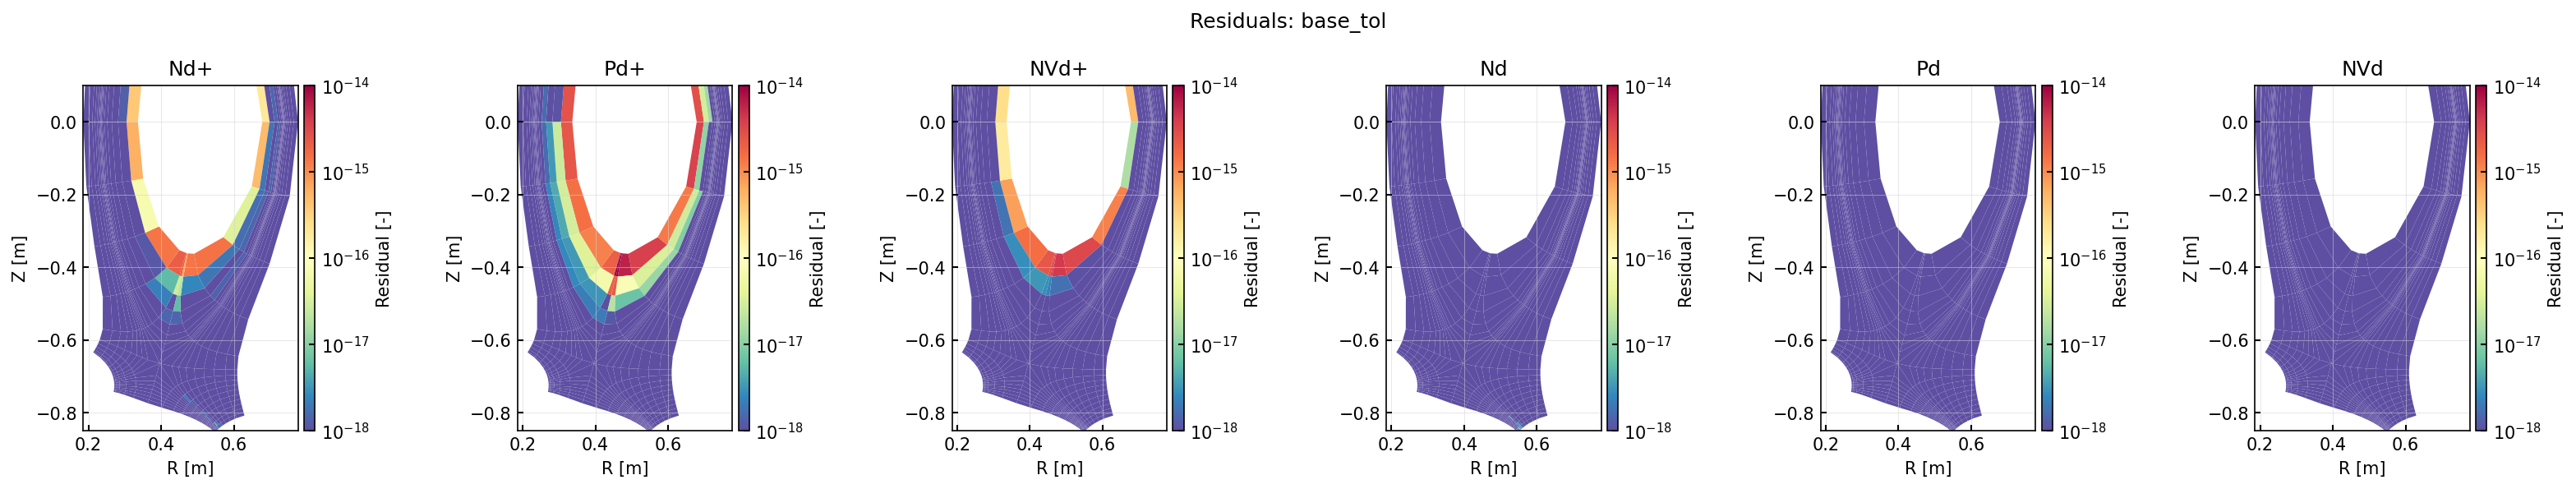

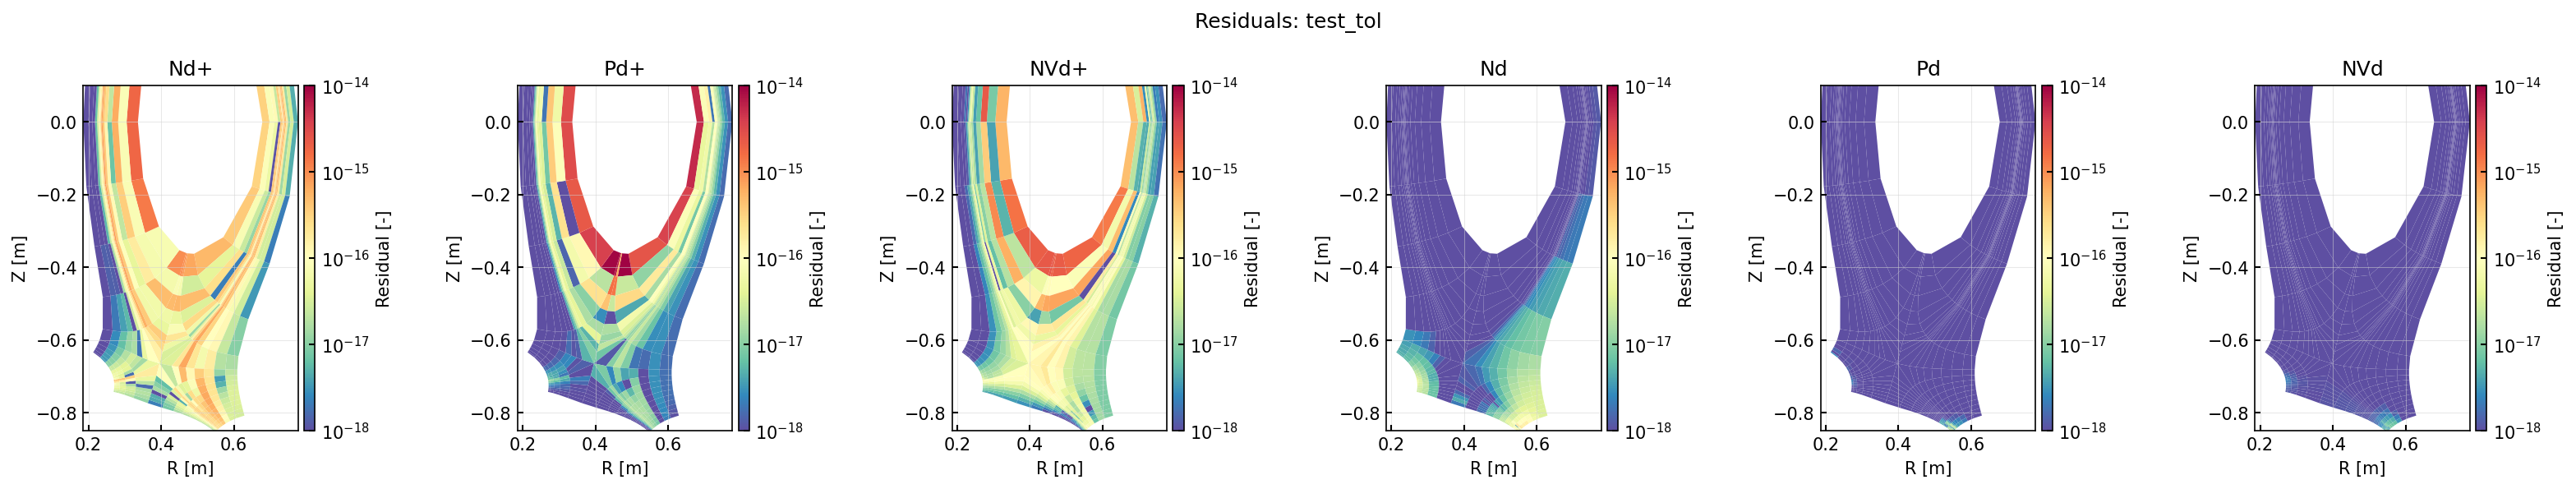

In [53]:
for case in cs:
    ds = cs[case].ds
    # ds = debug[case]
    sel = {"x" : slice(2,-2)}

    vmax = 1e-14
    vmin = 1e-18

    plot2d(
        [
            dict(data = abs(ds["residuum_Nd+"]), title = "Nd+", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["residuum_Pd+"]), title = "Pd+", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["residuum_NVd+"]), title = "NVd+", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["residuum_Nd"]), title = "Nd", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["residuum_Pd"]), title = "Pd", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["residuum_NVd"]), title = "NVd", vmin = vmin, vmax = vmax),
            ], 
            ylim = (-0.85, 0.1),
            title = f"Residuals: {case}",
            clean_guards = False,
            separatrix = False,
            w_pad = -4,
            cmap = "Spectral_r")

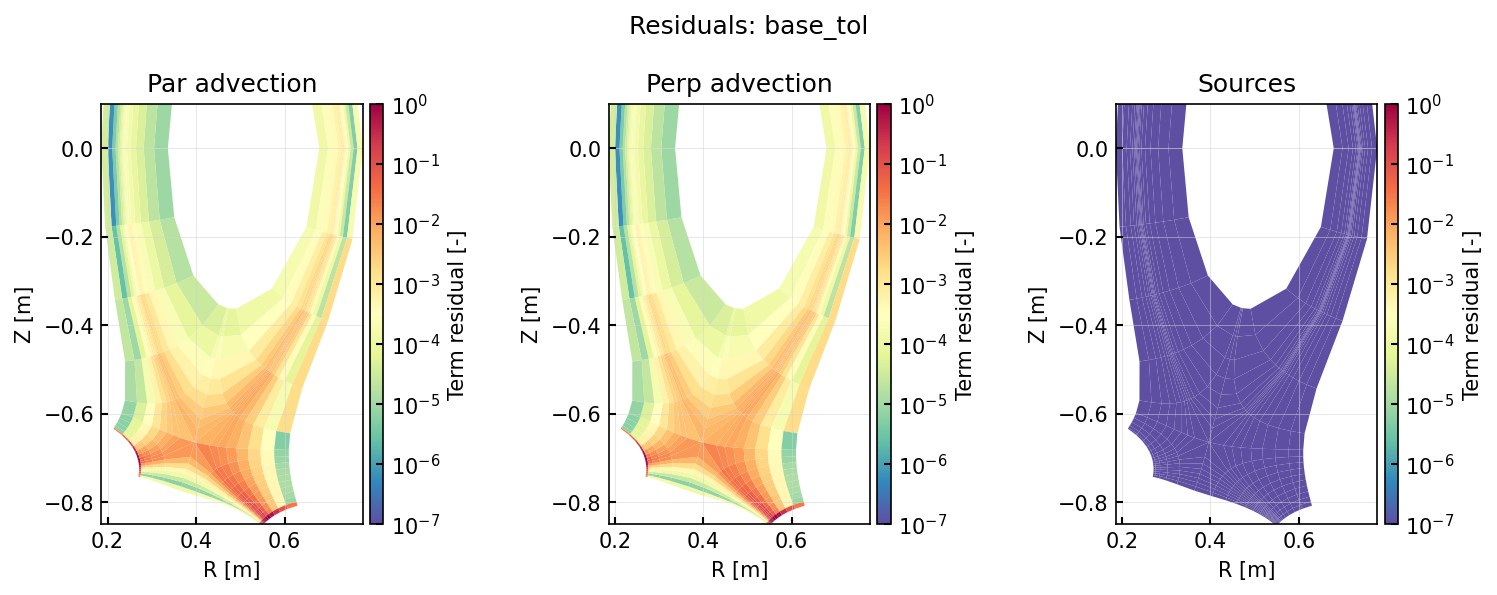

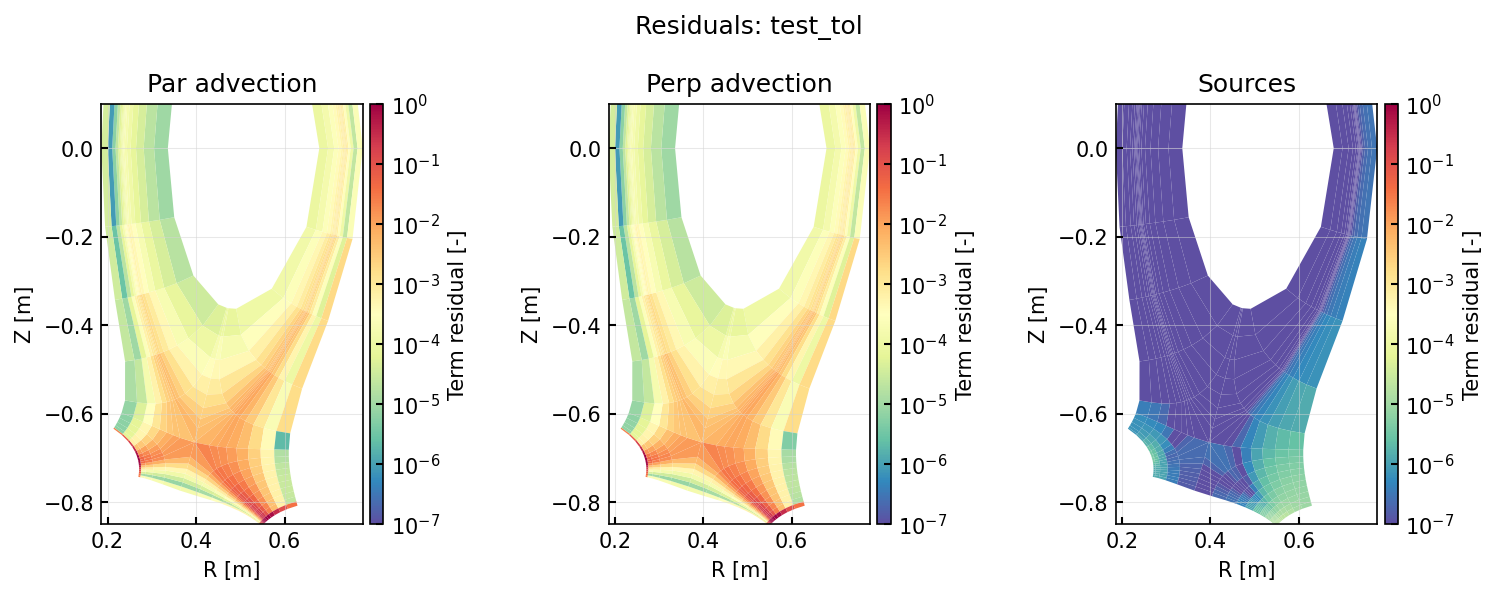

In [62]:
for case in cs:
    ds = cs[case].ds
    # ds = debug[case]
    sel = {"x" : slice(2,-2)}

    vmax = 1
    vmin = 1e-7

    plot2d(
        [
            dict(data = abs(ds["track_ddt_Nd_1"]), title = "Par advection", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["track_ddt_Nd_2"]), title = "Perp advection", vmin = vmin, vmax = vmax),
            dict(data = abs(ds["track_ddt_Nd_3"]), title = "Sources", vmin = vmin, vmax = vmax),
            ], 
            ylim = (-0.85, 0.1),
            title = f"Residuals: {case}",
            clean_guards = False,
            separatrix = False,
            w_pad = -4,
            cmap = "Spectral_r")

In [54]:
[print(x) for x in ds.data_vars if "ddt" in x]

ddt(NVd)
ddt(NVd+)
ddt(Nd)
ddt(Nd+)
ddt(Pd)
ddt(Pd+)
ddt(Pe)
track_ddt_NVd+_2
track_ddt_NVd+_3
track_ddt_NVd+_4
track_ddt_NVd+_5
track_ddt_NVd_1
track_ddt_NVd_2
track_ddt_NVd_3
track_ddt_NVd_4
track_ddt_NVd_5
track_ddt_Nd+_2
track_ddt_Nd+_3
track_ddt_Nd_1
track_ddt_Nd_2
track_ddt_Nd_3
track_ddt_Pd+_2
track_ddt_Pd+_3
track_ddt_Pd+_4
track_ddt_Pd+_5
track_ddt_Pd+_6
track_ddt_Pd_1
track_ddt_Pd_2
track_ddt_Pd_3
track_ddt_Pd_4
track_ddt_Pd_5
track_ddt_Pd_6
track_ddt_Pd_7
track_ddt_Pe_2
track_ddt_Pe_3
track_ddt_Pe_4
track_ddt_Pe_5
track_ddt_Pe_6


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [46]:
%matplotlib widget

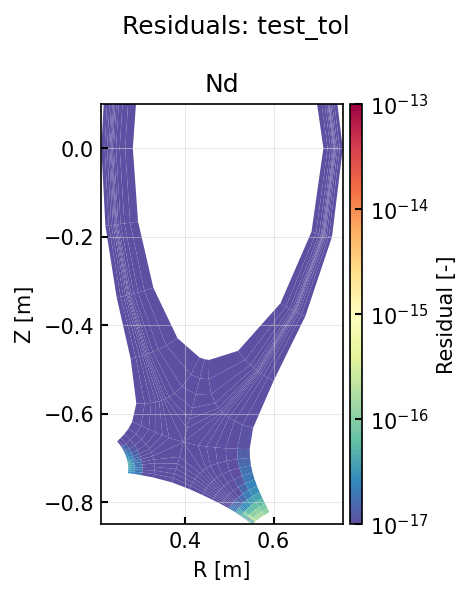

In [47]:
ds = cs["test_tol"].ds

plt.close("all")
vmax = 1e-13
vmin = 1e-17

plot2d(
    [
        # dict(data = abs(ds["residuum_Nd+"].isel(x = slice(2,-2))), title = "Nd+", vmin = vmin, vmax = vmax),
        # dict(data = abs(ds["residuum_Pd+"].isel(x = slice(2,-2))), title = "Pd+", vmin = vmin, vmax = vmax),
        # dict(data = abs(ds["residuum_NVd+"].isel(x = slice(2,-2))), title = "NVd+", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_Nd"].isel(x = slice(2,-2))), title = "Nd", vmin = vmin, vmax = vmax),
        # dict(data = abs(ds["residuum_Pd"].isel(x = slice(2,-2))), title = "Pd", vmin = vmin, vmax = vmax),
        # dict(data = abs(ds["residuum_NVd"].isel(x = slice(2,-2))), title = "NVd", vmin = vmin, vmax = vmax),
        ], 
        ylim = (-0.85, 0.1),
        title = f"Residuals: {case}",
        clean_guards = False,
        separatrix = False,
        w_pad = -4)

In [25]:
None + 1

/ssd_scratch/scripts/sdtools/hermes3/accessors.py:7: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @register_dataarray_accessor("hermesm")
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:44: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @register_dataset_accessor("hermesm")


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

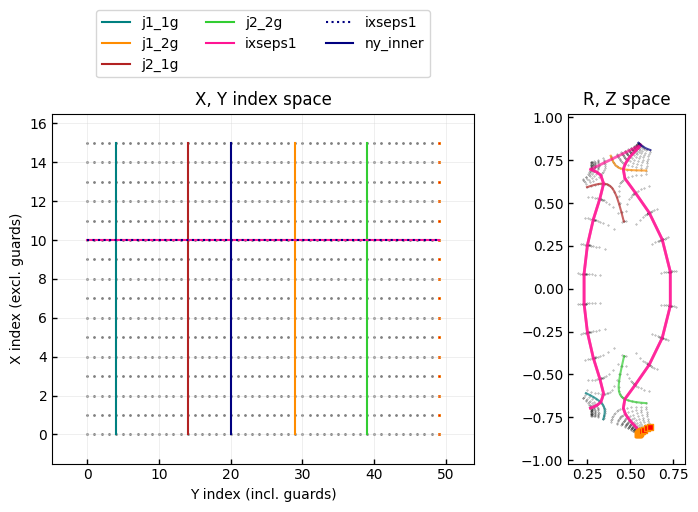

In [29]:
# plot_selection(ds, ds.isel(x = slice(None, None), theta = slice(0, 1)))
plot_selection(ds, ds.hermesm.select_region("outer_lower_target"))

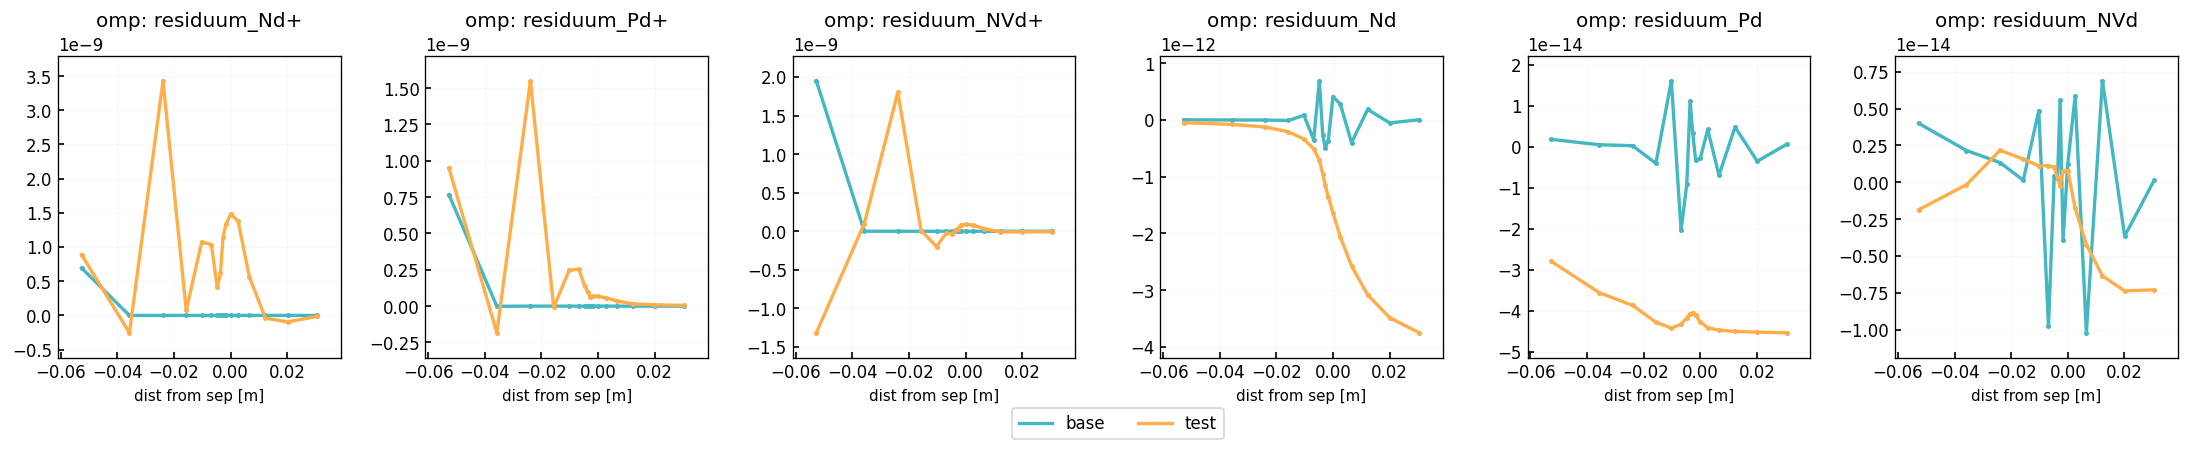

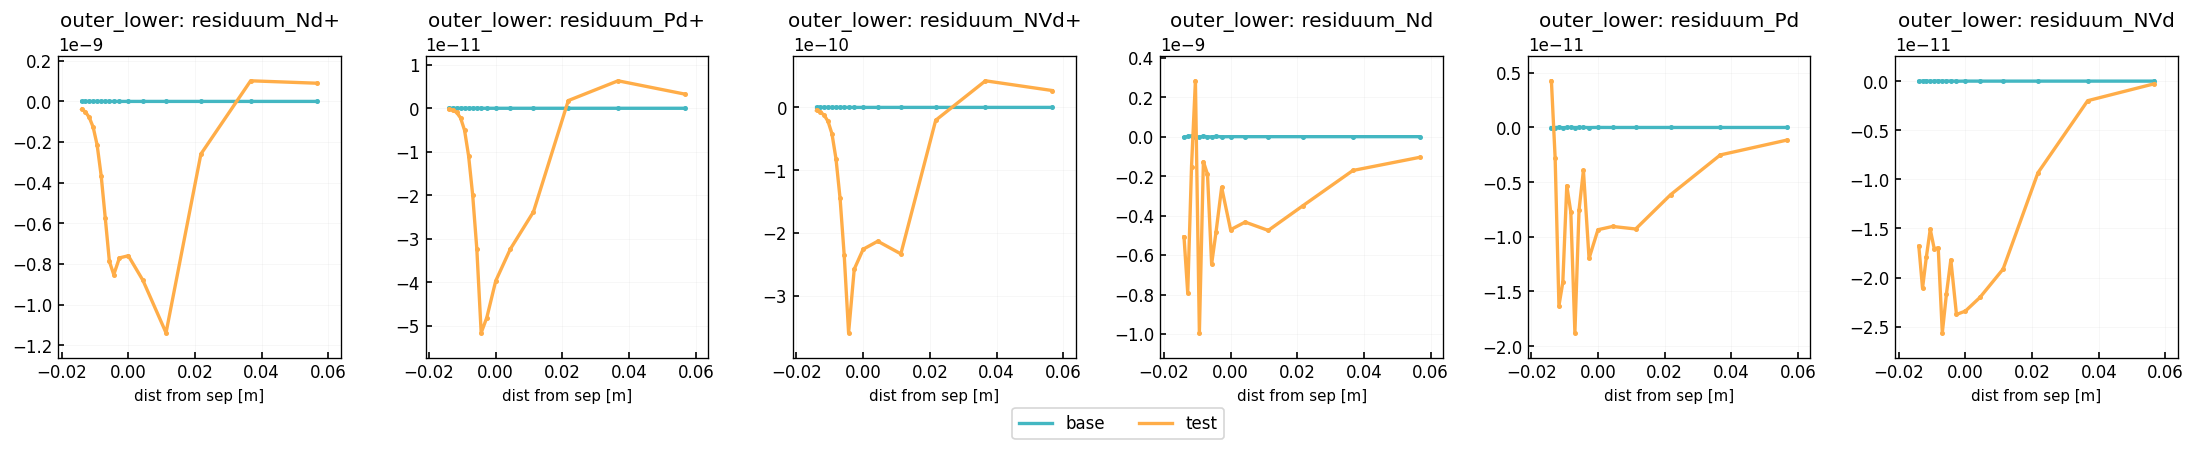

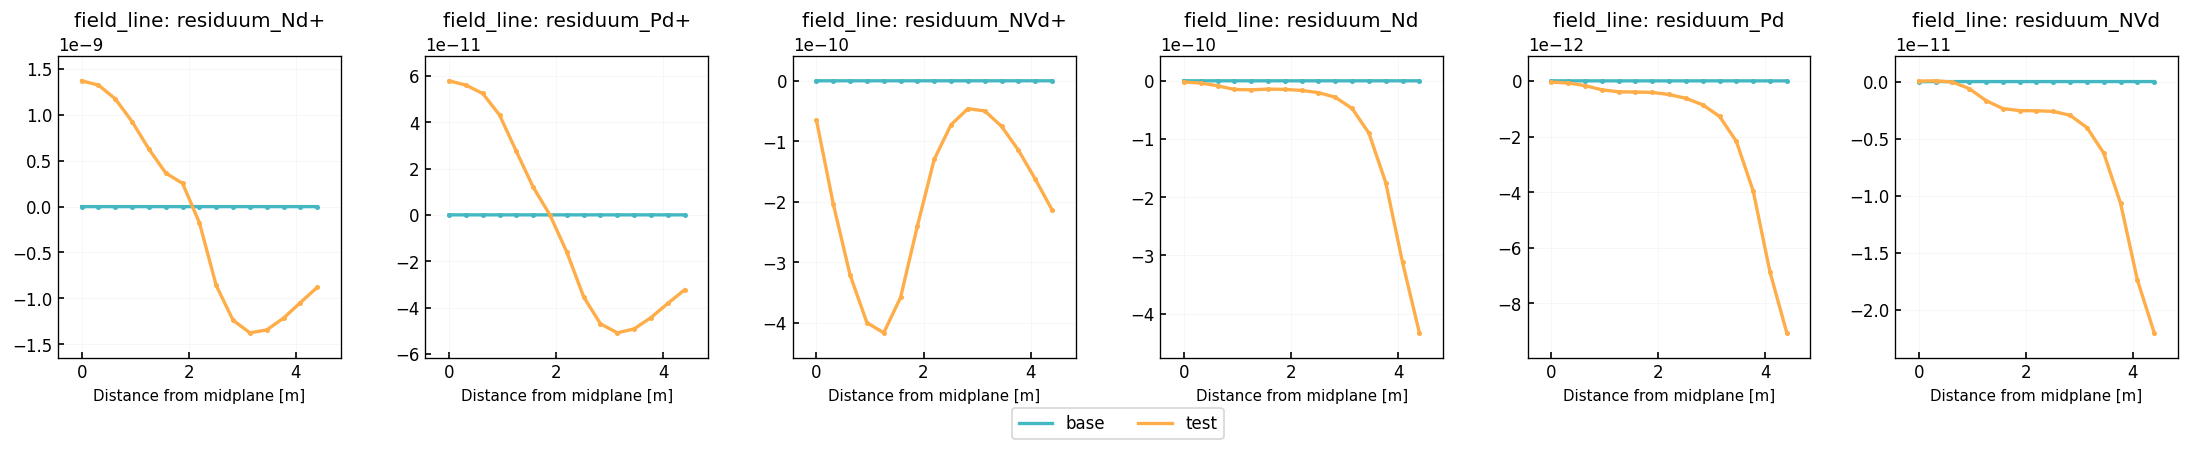

In [33]:
toplot = {}

for case in cs:
    toplot[case] = cs[case].ds

    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["residuum_Nd+", "residuum_Pd+", "residuum_NVd+", "residuum_Nd", "residuum_Pd", "residuum_NVd"],
    # params = ["Nd", "Dnnd"],
    regions = ["omp", "outer_lower", "field_line"],
    # regions = ["field_line"]
)

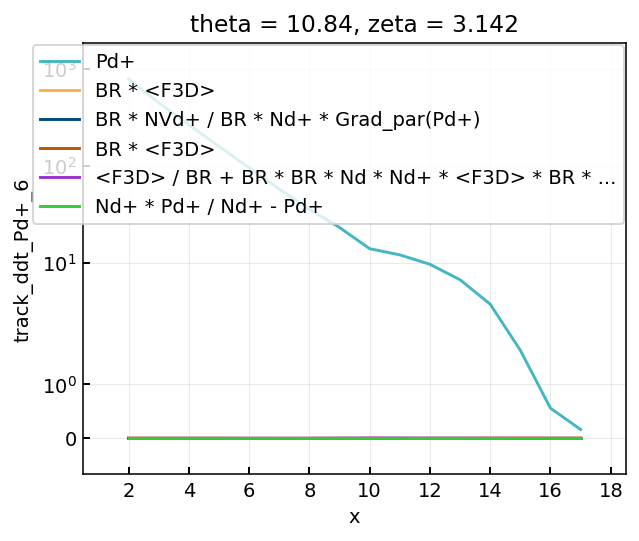

In [20]:
plt.figure()
k0 = "Pd+"
w = worst[k0]
isel = dict(x=slice(2,-2), theta=w[1])#, x=slice(2, -2))
for k in [k0] + [f"track_ddt_{k0}_{k}" for k in range(20)]:
    if k not in ds:
        continue
    label = ds[k].attrs.get("rhs.name", k)
    #print( ds[k].attrs)
    cutoff = 50
    if len(label) > cutoff:
        label=label[:cutoff-3] + "..."
    ds[k].isel(**isel).plot(label=label)
plt.yscale("symlog")
plt.legend()

if 0:
    plt.figure()
    for k in "Pe", "track_ddt_Pe_3", "track_ddt_Pe_5":
        np.log(np.abs(ds[k].isel(**isel))).plot(label=k)
    yll, ylu = plt.ylim()
    ylu -= yll
    ylu /= 4
    yll += ylu * 2
    for k in "Pe", "track_ddt_Pe_3", "track_ddt_Pe_5":
        (yll + ylu * np.sign(ds[k].isel(**isel))).plot(label="sign "+k)
    plt.legend()
#(ds.Pe.isel(**isel)).plot()
#(ds.track_ddt_Pe_3.isel(**isel)/1e-3).plot()
#(ds.track_ddt_Pe_5.isel(**isel)/1e-3).plot()


# Old

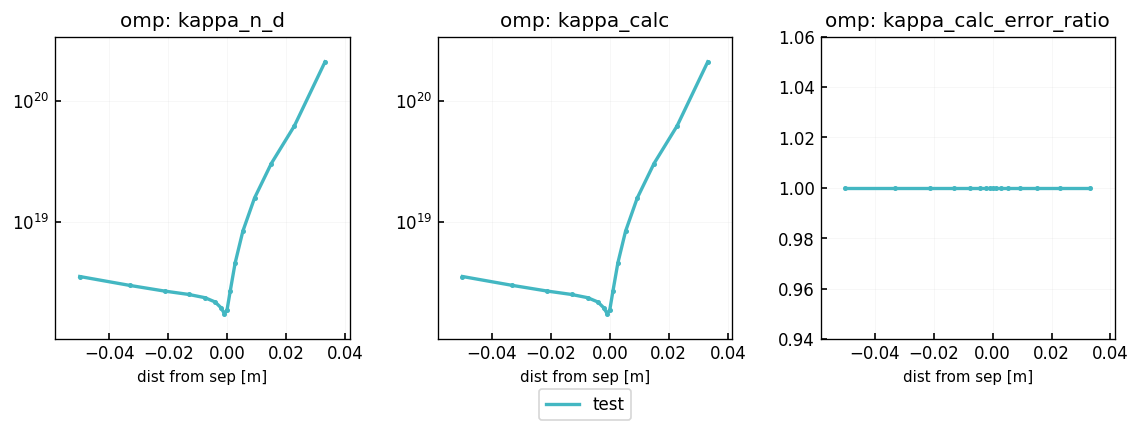

In [6]:
toplot = {}
for case in cs:
# for case in ["test_legacy", "test_afn"]:

    ds = cs[case].ds
    ds["kappa_ratio"] = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"]
    ds["kappa_unlim_calc"] = ds["Dnn_unlimd"] * ds["Nd"] * 5/2
    ds["kappa_unlim_calc_error"] = ds["kappa_n_unlimited_d"] / ds["kappa_unlim_calc"]
    
    gamma = 2
    ds["kappa_calc"] = ds["kappa_n_unlimited_d"] * (1 + (ds["kappa_n_unlimited_d"]/ds["kappa_n_max_d"])**(gamma))**(-1/gamma)
    ds["kappa_calc_error_ratio"] = ds["kappa_calc"] / ds["kappa_n_d"]
    if "t" in ds.dims: ds = ds.isel(t=-1)
    toplot[case] = ds.isel(x = slice(2,-2))

    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    # params = ["kappa_n_d", "kappa_n_unlimited_d", "Nd", "Dnnd", "kappa_n_max_d", "Dnn_unlimd"],
    params = ["kappa_n_d", "kappa_calc", "kappa_calc_error_ratio"],
    # params = ["Nd", "Dnnd"],
    # regions = ["omp", "imp", "outer_lower", "field_line"],
    regions = ["omp"]
)

In [ ]:
  alternative_precon = options["alternative_precon"]
                          .doc("Use alternative preconditioner?")
                          .withDefault<bool>(false);



  if (alternative_precon) {
    coef = -gamma * Dnn - gamma * kappa_n;
    inv->setCoefD(coef);
  }



In [4]:
[print(x) for x in ds.data_vars if "kappa" in x]

kappa_d
kappa_n_Dnchained_d
kappa_n_d
kappa_n_max_d
kappa_n_unlimited_d
kappa_par_d+
kappa_par_e
kappa_ratio
kappa_unlim_calc
kappa_unlim_calc_error


[None, None, None, None, None, None, None, None, None, None]

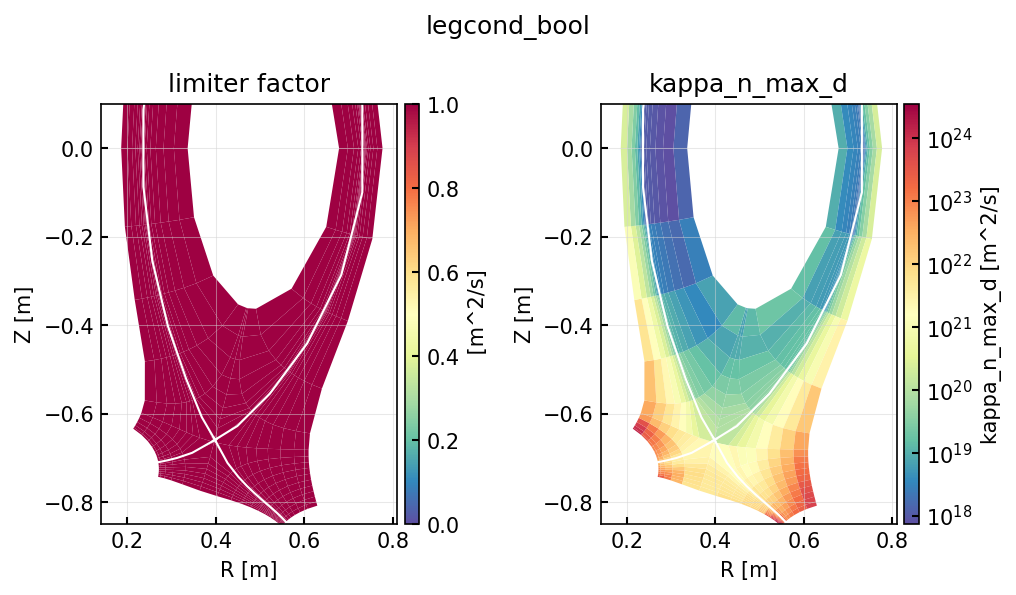

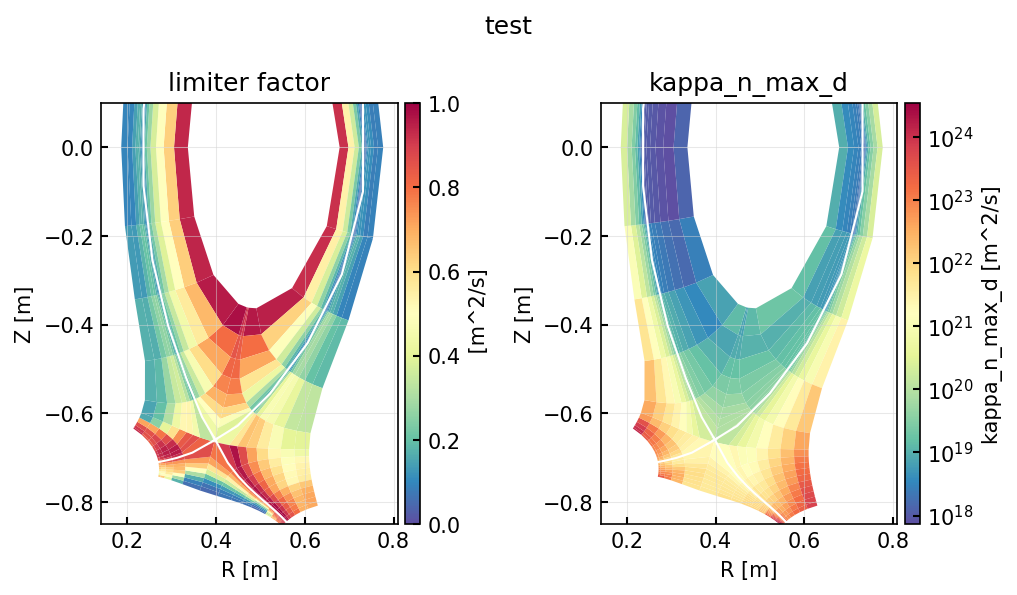

In [10]:
# for case in ["a1_mfp1e-4"]:
for case in cs:
# for case in ["base", "no_rnn_flim1"]:

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    plot2d(
        [
            dict(data = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"], title = "limiter factor", vmin = 0, vmax = 1, logscale = False),
            dict(data = ds["kappa_n_max_d"] , vmin = None, vmax = None),

            ], 
            ylim = (-0.85, 0.1),
            title = f"{case}")

In [ ]:
G = np.linspace(0,2000, 5000)
Gmax = 1000
gamma = 1

def make_glim(gamma):
    return G * (1 + (G/Gmax)**gamma)**(-1/gamma)


# plt.hlines(2000, G[0], G[-1], label = "Max", ls = "--", colors = "black")
plt.hlines(Gmax, G[0], G[-1], label = "Limit", ls = ":", colors = "black")
plt.vlines(Gmax, 0, Gmax, ls = ":", colors = "black")

plt.plot(G, make_glim(1), label = "gamma = 1")
plt.plot(G, make_glim(2), label = "gamma = 2")
plt.plot(G, make_glim(5), label = "gamma = 4")
plt.plot(G, make_glim(10), label = "gamma = 10")

plt.xlabel("Flux")
plt.legend(loc = "upper left", bbox_to_anchor=(1,1))
plt.ylabel("Limited flux")

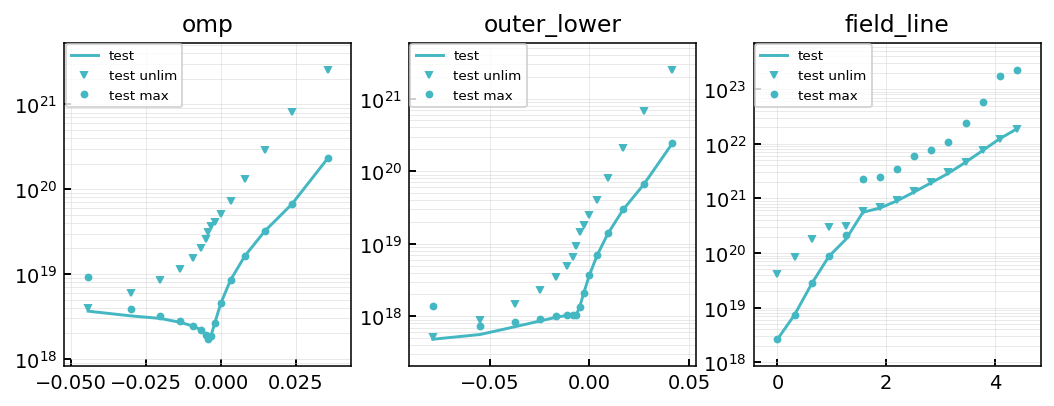

In [3]:
fig, axes = plt.subplots(1,3, figsize = (9,3))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


for i, case in enumerate(cs):
# for i, case in enumerate(["base"]):

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)

    regions = dict(
        omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2)).squeeze(),
        outer_lower = ds.hermesm.select_region("inner_midplane_a").isel(x=slice(2,-2)).squeeze(),
        field_line = ds.hermesm.select_custom_sol_ring(ds.metadata["ixseps1"], "outer_lower").squeeze()
    )

    

    for j, region in enumerate(regions):
        reg = regions[region]

        if region == "field_line":
            dist = reg.coords["theta"] - reg.coords["theta"][0]
        else:
            R = reg["dr"].cumsum()
            dist = (R - R[ds.metadata["ixseps1"]])

        ax = axes[j]
        ax.plot(dist, reg["kappa_n_d"], color = colors[i], label = f"{case}")
        ax.plot(dist, reg["kappa_n_unlimited_d"], color = colors[i], marker = "v", lw = 0, ms = 3,  label = f"{case} unlim")
        if case != "base": ax.plot(dist, reg["kappa_n_max_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")
        ax.set_title(region)
        # ax.plot(dist, reg["kappa_n_Dnchained_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")

        ax.legend(fontsize = "x-small")
        ax.set_yscale("log")

